<a href="https://colab.research.google.com/github/Levis0045/SCIA-CRF_LF/blob/0.1/training/experimentations_crf_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sangkak AI Challenge: POS tasks

--------------------------------------------------------------------------

- **Author**: Elvis MBONING (NTeALan Research and Development Team)
- **Session**: septembre 2023

--------------------------------------------------------------------------

In this notebook, we try to implement new methods which can potentialy improved POS task in low african resource languages.

We propose a rule-based approach call **Position to position entity augmentation** to normalize and augment lowest training data for CRF model. Our work is based on this paper (Xiang Dai and Heike Adel, 2020)[https://aclanthology.org/2020.coling-main.343.pdf].

# Experiments

In this experiment, we want to build ML model based on Conditional Random Field (CRF). 

## 1- Data processing and analysis

### 1.1. Loading data from Masakhane folder


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Install python packages dependencies
!pip3 install pandas python_crfsuite summarytools sklearn_crfsuite unidecode
!pip3 install iteration_utilities matplotlib

In [2]:
# Download Masakhane dataset from Github
!git clone https://github.com/masakhane-io/masakhane-pos.git
!mv masakhane-pos ../data_source/masakhane-pos

Clonage dans 'masakhane-pos'...
remote: Enumerating objects: 385, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 385 (delta 0), reused 0 (delta 0), pack-reused 382
Réception d'objets: 100% (385/385), 9.74 Mio | 21.41 Mio/s, fait.
Résolution des deltas: 100% (149/149), fait.


In [1]:
# loading default libraries
from pathlib import Path
import pandas as pd
from datetime import datetime
import joblib


In [21]:
# from auglib_pos import read_format_data

def read_pos_format_data(filename):
    sents_id, words, all_tags = [], [], []
    all_extracted_data = []
    with open(filename, encoding='utf-8') as iob:
        sentence, id_sent, tags = [], 1, []
        for line in iob:
            if len(line) > 1:
                word, tag = line.strip().split(' ')
                sentence.append((word.strip(), tag))
                sents_id.append(id_sent)
                words.append(word.strip())
                all_tags.append(tag)
                tags.append(tag)
            else:
                if sentence[-1][0] not in ['.','!','?']: 
                    # normalized punctuation at the end of all sentences
                    sents_id.append(id_sent)
                    sentence.append(('.', 'PUNCT'))
                    words.append('.')
                    all_tags.append('PUNCT')
                
                all_extracted_data.append(sentence)
                sentence, tags = [], []
                id_sent += 1
    print(len(sents_id),len(words), len(all_tags))
    dataframe = {"sentence_id": sents_id, "word": words, "tags": all_tags}
    pd_iob_data = pd.DataFrame.from_dict(dataframe)
    return all_extracted_data, pd_iob_data


def read_pos_format_data(filename):
    sents_id, words, all_tags = [], [], []
    all_extracted_data = []
    with open(filename, encoding='utf-8') as iob:
        sentence, id_sent, tags = [], 1, []
        for line in iob:
            if len(line) > 1:
                word, tag = line.strip().split(' ')
                sentence.append((word.strip(), tag))
                sents_id.append(id_sent)
                words.append(word.strip())
                all_tags.append(tag)
                tags.append(tag)
            else:
                if sentence[-1][0] not in ['.','!','?']: 
                    # normalized punctuation at the end of all sentences
                    sents_id.append(id_sent)
                    sentence.append(('.', 'PUNCT'))
                    words.append('.')
                    all_tags.append('PUNCT')
                
                all_extracted_data.append(sentence)
                sentence, tags = [], []
                id_sent += 1
    print(len(sents_id),len(words), len(all_tags))
    dataframe = {"sentence_id": sents_id, "word": words, "tags": all_tags}
    pd_iob_data = pd.DataFrame.from_dict(dataframe)
    return all_extracted_data, pd_iob_data

from sklearn.base import (
    BaseEstimator,
    TransformerMixin
)

class SangkakPosProjetReader(TransformerMixin, BaseEstimator):

    def __init__(self, copy=True):
        self.copy = copy

    def fit(self, file_path, y=None):  
        self.file_path = file_path
        if Path(file_path).exists():
            self.file_path = file_path
            return self
        else: raise Exception("File not found: %s" % file_path)

    def transform(self, file_path, copy=None, label=False):
        # check_is_fitted(self)
        _, pd_iob_data = read_pos_format_data(file_path)
        
        return pd_iob_data

    def transform_analysis(self):
        # check_is_fitted(self)
        extracted_data, pd_iob_data = read_pos_format_data(self.file_path)
        
        return extracted_data, pd_iob_data

    def _more_tags(self):
        return {"stateless": True}

In [3]:
# Reading folder path
# Context Masahkane community
# Universal dependency data format

language = 'bbj'

bbj_pos_path = Path(f'../data_source/masakhane-pos/data/{language}')
dev_data_path   = bbj_pos_path / 'dev.txt'
train_data_path = bbj_pos_path / 'train.txt'
test_data_path = bbj_pos_path / 'test.txt'



In [19]:
# read and extract iob data
reader_estimator = SangkakPosProjetReader()

extracted_train_data, pd_train_data = reader_estimator.fit(train_data_path).transform_analysis()
extracted_dev_data, pd_dev_data    = reader_estimator.fit(dev_data_path).transform_analysis()
extracted_test_data, pd_test_data  = reader_estimator.fit(test_data_path).transform_analysis()

# some stats 
print("Total number of sentences in the train dataset: {:,}".format(pd_train_data["sentence_id"].nunique()))
print("Total words in the train dataset: {:,}".format(pd_train_data.shape[0]))
print("Total number of sentences in the dev dataset: {:,}".format(pd_dev_data["sentence_id"].nunique()))
print("Total words in the dev dataset: {:,}".format(pd_dev_data.shape[0]))
print("Total number of sentences in the test dataset: {:,}".format(pd_test_data["sentence_id"].nunique()))
print("Total words in the test dataset: {:,}".format(pd_test_data.shape[0]))

# pas besoin de faire de la correlation à ce niveau: pas accès de valeur numérique
print(f"\nCorrelation: {pd_train_data.corr(numeric_only=True)}")


12347 12347 12347
2447 2447 2447
9315 9315 9315
Total number of sentences in the train dataset: 751
Total words in the train dataset: 12,347
Total number of sentences in the dev dataset: 149
Total words in the dev dataset: 2,447
Total number of sentences in the test dataset: 599
Total words in the test dataset: 9,315

Correlation:              sentence_id
sentence_id          1.0


In [20]:
# Transform training data to dataframe
pd_train_data

,sentence_id,word,tags
0,1,Mwɔ̌ʼ,NOUN
1,1,pfʉ́tə́,VERB
2,1,nə́,ADP
3,1,mwâsi,NOUN
4,1,máp,DET
...,...,...,...
12342,751,kə,AUX
12343,751,fǎʼ,VERB
12344,751,nə́,ADP
12345,751,é,PRON


In [23]:
# saving first dataframe data
project = "sangkak-09-2023"
build_date = str(datetime.now()).split(' ')[0]

joblib.dump({
    "train_data": pd_train_data, 
    "dev_data": pd_dev_data,
    "test_data": pd_test_data,
    "list_train_data": extracted_train_data,
    "list_dev_data": extracted_dev_data,
    "list_test_data": extracted_test_data
}, f'preprocessing/sangkak_input_df_data_{language}_{build_date}.joblib')


['preprocessing/sangkak_input_df_data_bbj_2023-08-21.joblib']

In [9]:
extracted_train_data[10]

[('Nə́', 'PART'),
 ('lə', 'VERB'),
 ('msə̌ŋwi', 'NOUN'),
 ('gwá', 'VERB'),
 ('shu', 'NOUN'),
 ('yə', 'DET'),
 ('boʼyɔ̂m', 'ADJ'),
 ('pəjyə́', 'NOUN'),
 ('səkúcyəgwɛ', 'NOUN'),
 ('á', 'DET'),
 ('ka', 'PART'),
 ('láʼtə́', 'VERB'),
 ('cuŋ', 'NOUN'),
 ('e', 'DET'),
 ('nə̂', 'ADP'),
 ('ntáknyə́', 'NOUN'),
 ('ntʉ́m', 'ADP'),
 ('Bînam', 'NOUN'),
 ('Sîsǐ', 'ADP'),
 ('gə́', 'CCONJ'),
 ('Bînam', 'NOUN'),
 ('ŋkàʼ', 'ADP'),
 ('.', 'PUNCT')]

### 1.3. Analyzing data 

In [12]:
# load dependents python packages
from matplotlib import pyplot as plt
import numpy as np

In [6]:
# quantification des tags/phrases dans le corpus d'entrainement
# credit: https://github.com/6chaoran/jupyter-summarytools
from summarytools import dfSummary, tabset

tabset({
    "train_data": dfSummary(pd_train_data).render(),
    "dev_data": dfSummary(pd_dev_data).render(),
    "test_data": dfSummary(pd_test_data).render(),
})

# Un controle visuel des données et ce tableau montre clairement qu'il y a 
# des problématiques de cohérence d'annotations avec l'usage du format IOB.

/tmp/ipykernel_111595/3771638669.py:6: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  "train_data": dfSummary(pd_train_data).render(),
/tmp/ipykernel_111595/3771638669.py:7: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  "dev_data": dfSummary(pd_dev_data).render(),
/tmp/ipykernel_111595/3771638669.py:8: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  "test_data": dfSummary(pd_test_data).render(),


No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,sentence_id[int64],Mean (sd) : 364.4 (216.0)min < med < max:1.0 < 363.0 < 751.0IQR (CV) : 374.0 (1.7),751 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/P9b71AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACq0lEQVR4nO3bTYriQByG8X+NX/GDBHHQnRcYmIVLDzGHnSO04An6Bu4EEUWnRY3OYtpZdaupMiZv8/zWJhbypFJVoDufzwaU3beiBwDco3rrA865ppnVPe+/P5/Pb57XAv9dDdU51+z1er/iOO763Hy9Xi+dc7+JFaFuzaj1OI674/H4LUmSXZYbr1araDqddheLRd3MCBVBbr76zcySJNn1+/0/WW+epmlsZrFzLvPA3rF0gJndGaqP7XZbOxwOP4fDYaVSqWSajS9YOuAit1D3+301iqLWaDTaDQaDZdbrQ5cOgZtAs4Jmc9Vx5y23UC/a7bbXsuFd0+ei0E2gWTGzueq4nyH3UEOkaVozvzVu3Ol0+uPxeJ11E2hW6EbQe/Nq9m/ck8mkv1gsvjvn1h7fX9rZuLShhqxxD4dDlKbpj0aj8fLs2dws6PUdn06nWpIkS59xh+4LyjwblzbUkDXubDbrvr6+to7HYyWv8X0m5PV9ecB2u92LmWUONeQ3K/txYmlDvfBZ4y6XS+/Z8AG8X9+PesB89wVlPk4sfaiqfM6ei3zAyn6cSKifCNnInU6nWg5DylXRx4m3EOoHHrGR811nFq2I48R7EOoHVDdyXxmhXiG4kStUwHLJ7MZGjFDxEHmf4RIqHiLvM1xCxUMFbMauLpn4zxQkECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokVO/50Gq1irLeeLPZRGZm2+02ms/nrWder/rdquMOvf6evv4CSIe7f9vPcu4AAAAASUVORK5CYII="">",0(0.0%)
2,word[object],1. .2. nə́3. á4. bə́5. lə6. pú7. a8. gaə́9. wə́10. é11. other,"699 (5.7%)417 (3.4%)307 (2.5%)216 (1.7%)188 (1.5%)184 (1.5%)174 (1.4%)164 (1.3%)156 (1.3%)155 (1.3%)9,687 (78.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/P9b71AAAACXBIWXMAAA9hAAAPYQGoP6dpAAAEPUlEQVR4nO3dTU4bWQBG0Wdk0WFiy0JiGSzAi+jF9iK8APaBkGsQ05nQgyQImp+o06lr5Jwzi/CgpFyVVaX3weLh4WFA4ezYF8DvQ2xkxEZGbGTERkZsZMRGRmxkxEZmMca4GGOc/+BzXx4eHg7B9XDClpeXl3+uVqvNex+apulusVj8JTj+j+Vqtdpst9vDer2+f+0D+/3+026329ze3p6PMcTGT1uOMcZ6vb6/urr6/M7nLqLr4YR5QCAjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjLLMb6eWXvrA+/9DP6L5TRNd7vdbjPeObM2TdPdGONLd1mcIhsEMgu/MovKW3c2dzJ+uVfXVdZUzOHFusqairm8ta6ypuKX81KXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzIvBi4ELc3l18GLgwhwcCydj8ELmtTubuxqzeDF4MXZhLs8GL8YuzOm1wYuxC7PwUpeM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3Ms8GLsQtzejF4MXZhLo6FkzF4IeMBgcy/v0Z9hTKbZ+sqyyrmdPZ9XbXdbg/fovvRn4OEn/K4rvr2b8sqZuMBgYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjcyLPycEc3m6rrKsYlaOhZOxriLz9M7mrsasHgcvxi7M7Wy1Wm2ur6+HsQtzOxtjjIuLi7+PfSGcPi91yYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyJyNMcbhcPjj2BfC6Tubpunu5ubG2IXZORZOxuCFjDsbGYMXMgYvZAxeyHipS0ZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZKyryFhXkbFBIGNdRcadjYx1FRnrKjLWVWS81CUjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiNj8ELG4IWMY+FkDF7IuLORMXghY/BCxuCFjJe6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kHEsnIzBCxkPCGR8jZKxriJjXUXGuoqMBwQyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOBZOxrqKjDsbGYMXMgYvZAxeyHipS0ZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxnHwskYvJB5emfjtB39m+tx8HLMi2B+H2HQtFytVpvtdntYr9f3x7oI5rXf7z/tdrvN7e3t+RjjeLGNMcZ6vb6/urr6fKyLIHFx7AvwUpeM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3McoyvR1COfSHM56P8/y6nabrb7Xab8QGOoDCfjzBociz893H0Y+EGL2Q8IJARGxmxkREbGbGRERsZsZERGxmxkfkHaXbn0rJbgZ4AAAAASUVORK5CYII="">",0(0.0%)
3,tags[object],1. NOUN2. VERB3. PRON4. DET5. PUNCT6. PART7. PROPN8. AUX9. ADP10. SCONJ11. other,"2,502 (20.3%)2,045 (16.6%)1,308 (10.6%)956 (7.7%)870 (7.0%)811 (6.6%)772 (6.3%)694 (5.6%)663 (5.4%)516 (4.2%)1,210 (9.8%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/P9b71AAAACXBIWXMAAA9hAAAPYQGoP6dpAAAELElEQVR4nO3dMW7bWABF0a+BEUwaCYYBL8aLmMXOIrQbw7CKJEijFGljihSZy8LnbIAuLr5Ags88XK/XAYV/9v4D+DzERkZsZMRGRmxkxEZGbGTERkZsZA5jjK9jjC87Xf/n9Xr9vtO1iT08PT39dzweH/e4+OVyeTscDv8L7nN4OB6Pjy8vL99Pp9OP8sLv7+//ns/nx9fX1y9jDLF9Ag9jjHE6nX48Pz9/2+H6X3e4Jjtxg0BGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGQexvj9bll94T2uyb4eLpfL2/l8fhw7vFt2uVzexhg/6+uyDxsEMgf/M

<AxesSubplot: >

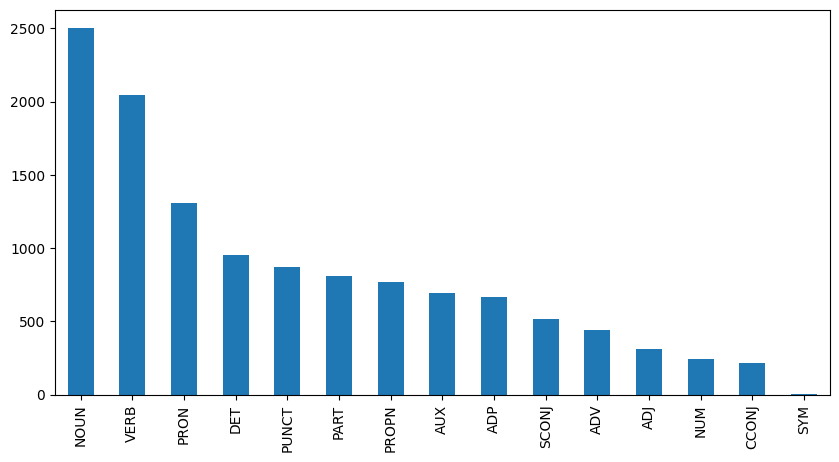

In [14]:
# representation of each entity tag
pd_train_data["tags"].value_counts().plot(kind="bar", figsize=(10,5))

# On remarque ici que le tag date représente 40% des tags (en position I ou B)

<AxesSubplot: >

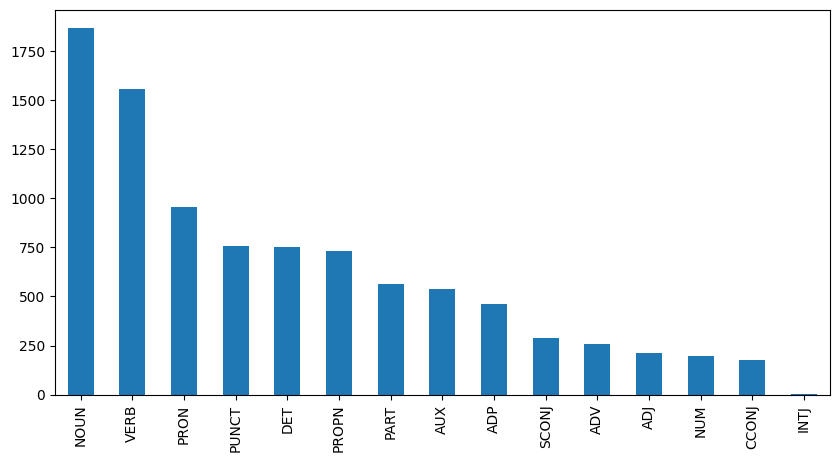

In [9]:
pd_test_data["tags"].value_counts().plot(kind="bar", figsize=(10,5))


<AxesSubplot: >

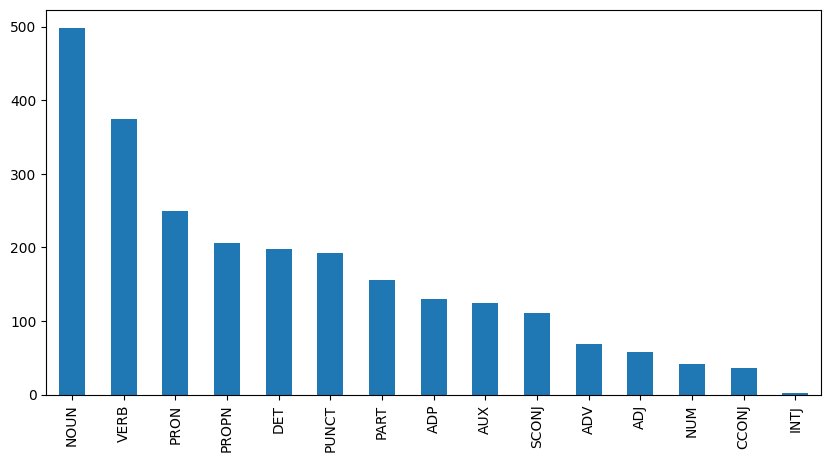

In [10]:
pd_dev_data["tags"].value_counts().plot(kind="bar", figsize=(10,5))


La phrase la plus longue contient 47 mots.
ID de la plus longue phrase 4.

La phrase la plus longue du corpus est:
 Fə̂ é Samuel Mvondo Ayolo gɔ síŋ wɔ́kpə pâʼ a kə́ shyətə tə́ e cyâ é gaə́ é ghɔ́ bá nə̂ e bə e katə kúʼ nə́ nə̂ŋ mghɛcɛ́ Mendize pyə wáp kə̂ shə́ŋ â daʼ nə́ nə̂ pfʉ̌ pfʉ́ m nə̂ bǔ pɔ páp lə .


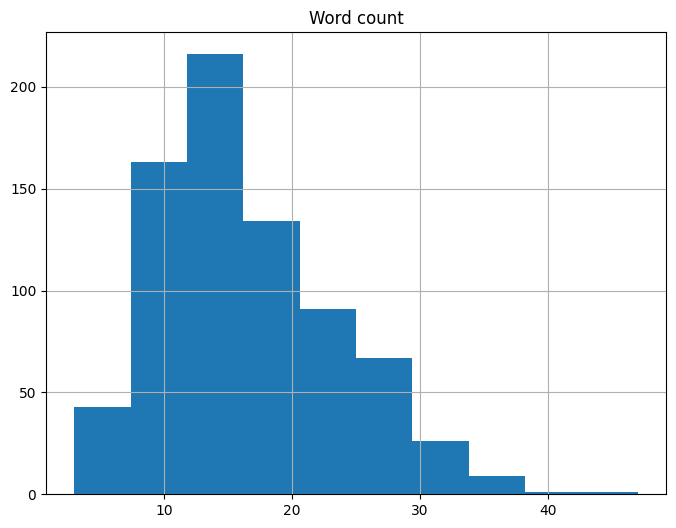

In [15]:

word_counts = pd_train_data.groupby("sentence_id")["word"].agg(["count"])
word_counts = word_counts.rename(columns={"count": "Word count"})
word_counts.hist(bins=10, figsize=(8,6))

# On constate que le nombre de mots moyens par phrase est de 15
MAX_LENGTH_SENTENCE = word_counts.max()[0]
print("La phrase la plus longue contient {} mots.".format(MAX_LENGTH_SENTENCE))
longest_sentence_id = word_counts[word_counts["Word count"]==MAX_LENGTH_SENTENCE].index[0]
print("ID de la plus longue phrase {}.".format(longest_sentence_id))
longest_sentence = pd_train_data[pd_train_data["sentence_id"]==longest_sentence_id]["word"].str.cat(sep=' ')
print(f"\nLa phrase la plus longue du corpus est:\n {longest_sentence}")


In [16]:
all_words = list(set(pd_train_data["word"].values))
all_tags = list(set(pd_train_data["tags"].values))

print("Nombre de mots uniques: {}".format(pd_train_data["word"].nunique()))
print("Nombre de tags uniques : {}".format(pd_train_data["tags"].nunique()))

Nombre de mots uniques: 2841
Nombre de tags uniques : 15


In [126]:
eth = 'ə́'
eeth = 'ɛ́'
ath = "ǝ́ "
print(len(eth), len(ath.strip()), ath.strip())

for x in eth:
    print(x)


t = "◌̀ ".strip() + "et"
print(dir(t), )
print(t, t.swapcase())

import unicodedata
print(dir(unicodedata))

" | ".join(list(pd_train_data["word"]))

2 2 ǝ́
ə
́
